In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image

In [2]:
# Path to file (for Colab)
PATH = ""

# Dataset
<a href="https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data">Amazon Dataset</a>

# Data Understanding

In [3]:
# See the shape of all images:
# Main Directory
main_path = PATH + 'AmazonDataset/'


def get_size(folder):
    sizes = []
    # Get from main directory all sub-directories
    for folder_path in os.listdir(folder):
        # Skip
        if (folder_path == '.DS_Store'):
            continue
        # See Train and Test sub-directories
        for folder_name in os.listdir(os.path.join(folder, folder_path)):
            # Skip
            if (folder_name in ['.DS_Store', 'test_v2_file_mapping.csv', 'train_v2.csv']):
                continue
            print(folder_name)
            for filename in os.listdir(os.path.join(folder, folder_path, folder_name)):
                
                # take image
                img = Image.open(os.path.join(folder, folder_path, folder_name, filename))
                # Get image with 
                #print(img.size)
                # Stores data like: (width, height)
                sizes.append(img.size)
            
    print(f'the max width is: {max(sizes[0])}, and the min width is: {min(sizes[0])}')
    print(f'the max height is: {max(sizes[1])}, and the min height is: {min(sizes[1])}')
    print(f'the mean width is: {np.mean(sizes[0])}, and the mean height is: {np.mean(sizes[1])}')

# Call the function
get_size(main_path)

test-jpg
train-jpg
the max width is: 256, and the min width is: 256
the max height is: 256, and the min height is: 256
the mean width is: 256.0, and the mean height is: 256.0


In [4]:
train_path = PATH + 'AmazonDataset/Train/'
test_path = PATH + 'AmazonDataset/Test/'

## See Images

In [5]:
images_folder_train = train_path + '/train-jpg/'
images_folder_test = test_path + '/test-jpg/'

In [6]:
import matplotlib.pyplot as plt
def plot_images(axis=(2,2), images_folder_path=images_folder_train, train = True):
    
    if train:
        train = 'train_'
    else:
        train = 'test_'
        
    # Grid
    f, axarr = plt.subplots(axis[0], axis[1], figsize=(30/axis[1], 10))
    
    for i in range(0,axis[0]):
        for j in range (0,axis[1]):
            # Choose a random image
            index_img = np.random.randint(100)
            filename = images_folder_path + train + str(index_img) + '.jpg'
            # Read Image:
            img = Image.open(filename).convert('RGB')
            # To numpy
            img = np.asarray(img)
            # Plot
            axarr[i,j].imshow(img)
    plt.show()

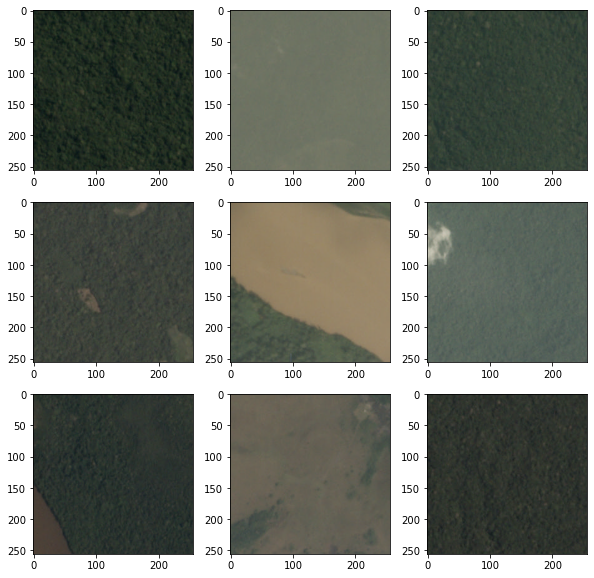

In [7]:
plot_images(axis=(3,3), images_folder_path=images_folder_train)

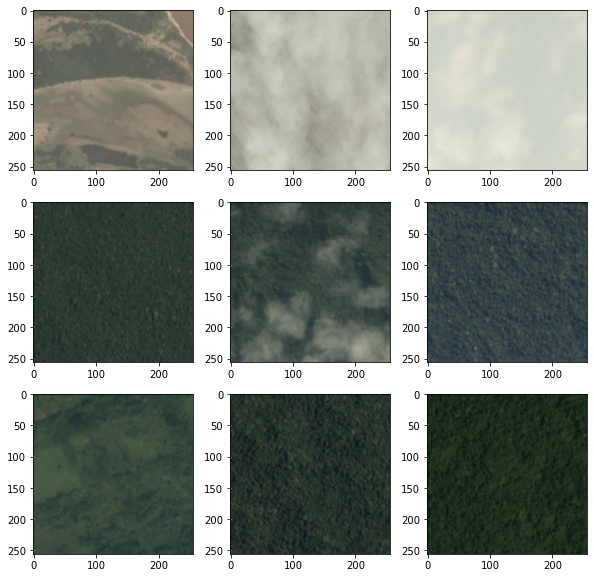

In [8]:
plot_images(axis=(3,3), images_folder_path=images_folder_test, train=False)

## See Labels

In [9]:
train_path_labels = train_path + 'train_v2.csv'
test_path_labels = test_path + 'test_v2_file_mapping.csv'

In [10]:
# Train Images and labels
train_map = pd.read_csv(train_path_labels)
train_map

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [11]:
pd.read_csv(test_path_labels)

,old,new
0,file_4158.tif,file_18830.tif
1,file_1668.tif,file_19164.tif
2,file_2411.tif,file_15749.tif
3,file_16047.tif,file_7531.tif
4,file_1271.tif,file_18347.tif
...,...,...
20517,file_17774.tif,file_14520.tif
20518,file_3538.tif,file_6633.tif
20519,file_1923.tif,file_4685.tif
20520,file_14047.tif,file_14571.tif


# Create Dataset
* This is a multi labels task, so we need binary encode the tags
* We don't have labels for testing images so we need to split data of train in train and test
* We have many information so we need a data loader to wrap-up the data and avoid overload the GPU or RAM

## Binary Encode

In [12]:
tags_encode = train_map.tags.str.get_dummies(sep=' ').columns
tags_encode

Index(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down',
       'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation',
       'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging',
       'slash_burn', 'water'],
      dtype='object')

In [13]:
# Select Tags
list_tags = ['agriculture', 'bare_ground', 'cultivation', 'habitation', 'primary', 'road', 'water']

## Filter images with tags 
* We have many tags, but we just want images with tags in list_tags so we filter

In [14]:
def filter_item(tag_string):
    res = any(tag in tag_string for tag in list_tags)
    return res    

In [15]:
train_map = train_map[train_map.tags.apply(lambda tag_string: filter_item(tag_string))]
train_map

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40473,train_40473,agriculture clear habitation primary road
40474,train_40474,clear primary
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


## Binary Encode and desired columns 

In [16]:
# Binary Encode
encode = train_map.tags.str.get_dummies(sep=' ')
train_map = pd.concat([train_map, encode], axis=1)
train_map.drop(columns=["tags"], inplace=True)
list_tags.insert(0,'image_name')
train_map = train_map[list_tags]
list_tags.pop(0)
train_map

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
0,train_0,0,0,0,0,1,0,0
1,train_1,1,0,0,0,1,0,1
2,train_2,0,0,0,0,1,0,0
3,train_3,0,0,0,0,1,0,0
4,train_4,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...
40473,train_40473,1,0,0,1,1,1,0
40474,train_40474,0,0,0,0,1,0,0
40476,train_40476,1,0,0,0,1,0,0
40477,train_40477,1,0,0,0,1,1,0


### Add ".jpg" to image name

In [17]:
train_map.image_name = train_map.image_name.apply(lambda name: name + '.jpg')
train_map

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
0,train_0.jpg,0,0,0,0,1,0,0
1,train_1.jpg,1,0,0,0,1,0,1
2,train_2.jpg,0,0,0,0,1,0,0
3,train_3.jpg,0,0,0,0,1,0,0
4,train_4.jpg,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...
40473,train_40473.jpg,1,0,0,1,1,1,0
40474,train_40474.jpg,0,0,0,0,1,0,0
40476,train_40476.jpg,1,0,0,0,1,0,0
40477,train_40477.jpg,1,0,0,0,1,1,0


the images with agriculture are 12315
the images with bare_ground are 862
the images with cultivation are 4477
the images with habitation are 3660
the images with primary are 37513
the images with road are 8071
the images with water are 7411


<AxesSubplot:>

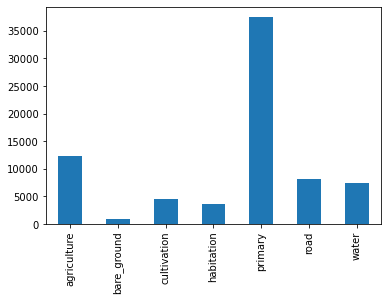

In [18]:
for item in list_tags:
    print(f'the images with {item} are {len(train_map[train_map[item] == 1])}')

train_map[list_tags].sum().plot.bar()

# Train, Test, Validation Split

In [19]:
from sklearn.model_selection import train_test_split

# Split Train and test
train, test = train_test_split(train_map, test_size=0.2, random_state=1)

# Split Train and validation
train, validation = train_test_split(train_map, test_size=0.1, random_state=1)

In [20]:
train

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
23491,train_23491.jpg,1,0,0,0,1,0,1
6046,train_6046.jpg,1,0,0,0,1,1,0
8878,train_8878.jpg,1,0,1,0,1,0,0
26987,train_26987.jpg,1,0,0,0,1,0,0
4478,train_4478.jpg,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
8247,train_8247.jpg,0,0,0,0,1,0,0
34311,train_34311.jpg,0,0,0,0,1,1,1
5486,train_5486.jpg,0,0,0,0,1,0,0
12866,train_12866.jpg,1,0,0,0,1,0,0


In [21]:
test

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
16249,train_16249.jpg,1,0,0,0,1,1,0
37026,train_37026.jpg,1,0,0,1,1,1,1
4720,train_4720.jpg,1,0,1,0,1,0,0
7175,train_7175.jpg,1,0,0,0,1,1,0
6325,train_6325.jpg,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...
27230,train_27230.jpg,0,0,0,0,1,0,0
7530,train_7530.jpg,1,1,0,0,1,1,1
33024,train_33024.jpg,0,0,0,0,1,0,0
18737,train_18737.jpg,0,0,0,0,1,0,0


In [22]:
validation

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
16249,train_16249.jpg,1,0,0,0,1,1,0
37026,train_37026.jpg,1,0,0,1,1,1,1
4720,train_4720.jpg,1,0,1,0,1,0,0
7175,train_7175.jpg,1,0,0,0,1,1,0
6325,train_6325.jpg,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...
22221,train_22221.jpg,0,0,0,0,1,0,0
29893,train_29893.jpg,1,0,0,1,1,1,0
35028,train_35028.jpg,0,0,0,0,1,1,0
24796,train_24796.jpg,0,0,0,0,1,0,0


# Creating data Generator and Data Agumentation

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# We can't load all data in memory at once, so we use a DataGenerator
#Create instance of ImageDataGenerator Class
image_gen_train = ImageDataGenerator(
                    # Rescale
                    rescale=1./255,
                    # Rotate 30
                    rotation_range=30,
                    # Shift pixel values
                    width_shift_range=.15,
                    height_shift_range=.15,
                    # Flip all image
                    horizontal_flip=True,
                    # Random zoom
                    zoom_range=0.4
                    )
image_gen_test = ImageDataGenerator(rescale=1./255)
image_gen_valid = ImageDataGenerator(rescale=1./255)

Init Plugin
Init Graph Optimizer
Init Kernel


In [24]:
width = 256 # width = height
batch_size = 16

# Custom datagenerator
train_datagen = image_gen_train.flow_from_dataframe(dataframe=train,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="raw",
                                                    target_size=(width,width))
                                                                
test_datagen = image_gen_test.flow_from_dataframe(dataframe=test,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=False,
                                                    class_mode="raw",
                                                    target_size=(width,width))

valid_datagen = image_gen_valid.flow_from_dataframe(dataframe=validation,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="raw",
                                                    target_size=(width,width))



Found 34548 validated image filenames.
Found 7678 validated image filenames.
Found 3839 validated image filenames.


In [25]:
import matplotlib.pyplot as plt
def plot_images_datagen(axis=(2,2), images=None):

    # Grid
    f, axarr = plt.subplots(axis[0], axis[1], figsize=(30/axis[1], 10))
    index = 0
    for i in range(0,axis[0]):
        for j in range (0,axis[1]):
            # Plot
            axarr[i,j].imshow(images[index])
            index += 1
    plt.show()

Found 3839 validated image filenames.


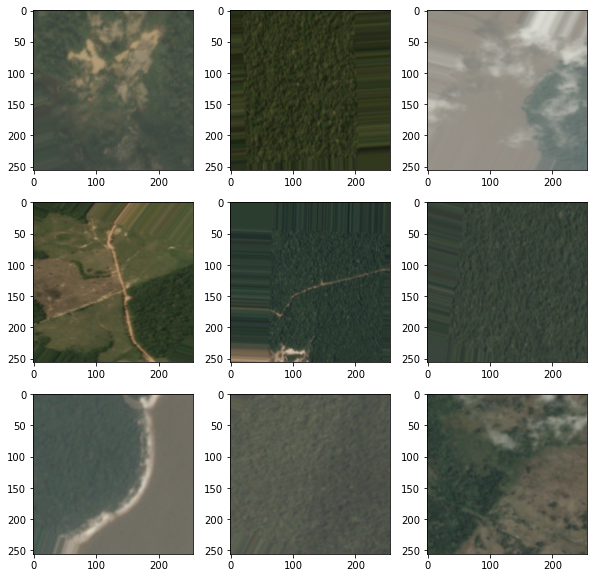

In [27]:
# See Example of image datagenerator
example = image_gen_train.flow_from_dataframe(dataframe=validation,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="raw",
                                                    target_size=(width,width))


images, _ = next(example)
example_images = images[:9]
plot_images_datagen(axis=(3,3), images=example_images)

# Create Model
* <a href="https://arxiv.org/abs/2010.11929">Convolutional ViT </a>

In [28]:
# See if GPU is aviable
import tensorflow as tf

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Convolutional Visual Transformer

### Configure the hyperparameters

In [29]:
num_classes = len(list_tags)
input_shape = (256, 256, 3)

In [30]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 100
image_size = 256  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Implement multilayer perceptron (MLP)

In [31]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [32]:
from tensorflow.keras import layers
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Metal device set to: Apple M1
Image size: 256 X 256
Patch size: 16 X 16
Patches per image: 256
Elements per patch: 768


2021-10-06 11:46:34.393883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-06 11:46:34.394596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


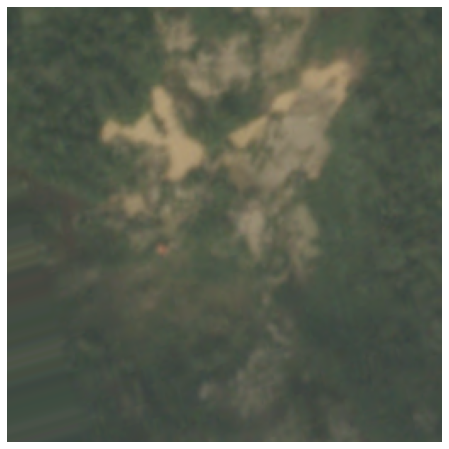

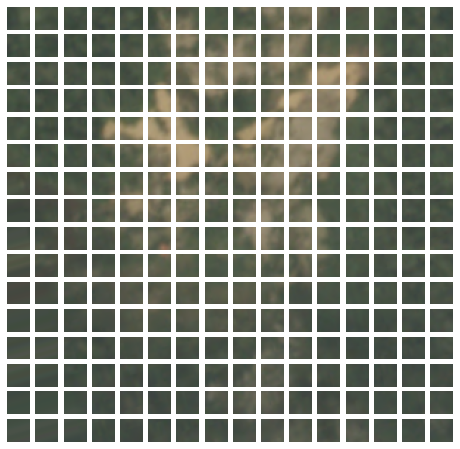

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(example_images[0])
plt.axis("off")



patches = Patches(patch_size)(np.expand_dims(example_images[0], axis=0))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

## Implement the patch encoding layer

In [34]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model

Architecture:
<img src="https://neurohive.io/wp-content/uploads/2020/10/archhhh2-770x388.png">


In [35]:
from tensorflow import keras

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation='sigmoid')(features)
    
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [35]:
np.random.seed(1)
tf.random.set_seed(1234)

model = create_vit_classifier()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 768)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 256, 256)     262400      patches_1[0][0]                  
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 256, 256)     512         patch_encoder[0][0]              
______________________________________________________________________________________________

# Compile the Model

In [36]:

"""
optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)
"""

model.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy',
    metrics = ['categorical_accuracy','accuracy'],
)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath = "Models/ViT/tmp/checkpoint"

keras_callbacks   = [
    # EarlyStopping:
    EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                  verbose=1, mode='auto', restore_best_weights=True),
    # ModelCheckpoint
    ModelCheckpoint(checkpoint_filepath, monitor="val_loss", 
                    save_best_only=True, save_weights_only=True,)
]

## Fit

In [39]:
STEP_SIZE_TRAIN = train_datagen.n//train_datagen.batch_size
STEP_SIZE_VALID = valid_datagen.n//valid_datagen.batch_size
STEP_SIZE_TEST = test_datagen.n//test_datagen.batch_size

In [39]:
# https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/Model#fit
history = model.fit(
    x = train_datagen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_datagen,
    validation_steps=STEP_SIZE_VALID,
    epochs=num_epochs,
    callbacks=keras_callbacks
    )

2021-09-27 22:39:05.389534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-27 22:39:05.391037: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2021-09-27 22:39:07.577603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2159/2159 [==============================] - ETA: 0s - loss: 0.4899 - categorical_accuracy: 0.6091 - accuracy: 0.6091

2021-09-28 00:42:07.596562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2159/2159 [==============================] - 7621s 4s/step - loss: 0.4899 - categorical_accuracy: 0.6091 - accuracy: 0.6091 - val_loss: 0.3610 - val_categorical_accuracy: 0.6098 - val_accuracy: 0.6098
Epoch 2/100
2159/2159 [==============================] - 6967s 3s/step - loss: 0.3616 - categorical_accuracy: 0.6109 - accuracy: 0.6109 - val_loss: 0.3618 - val_categorical_accuracy: 0.6106 - val_accuracy: 0.6106
Epoch 3/100
2159/2159 [==============================] - 6965s 3s/step - loss: 0.3617 - categorical_accuracy: 0.6109 - accuracy: 0.6109 - val_loss: 0.3621 - val_categorical_accuracy: 0.6096 - val_accuracy: 0.6096
Epoch 4/100
2159/2159 [==============================] - 7124s 3s/step - loss: 0.3618 - categorical_accuracy: 0.6109 - accuracy: 0.6109 - val_loss: 0.3623 - val_categorical_accuracy: 0.6088 - val_accuracy: 0.6088
Epoch 5/100
2159/2159 [==============================] - 7248s 3s/step - loss: 0.3619 - categorical_accuracy: 0.6109 - accuracy: 0.6109 - val_loss: 0.3615 - val

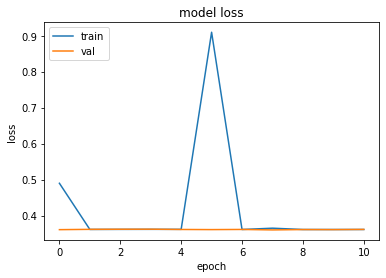

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test

In [47]:
# Predict 
#test_datagen.reset()

checkpoint_filepath = 'Models/VisualTransformer/VisualTransformer'

np.random.seed(1)
tf.random.set_seed(1234)
model = create_vit_classifier()
model.load_weights(checkpoint_filepath).expect_partial()


pred = model.predict_generator(test_datagen,
                            steps=STEP_SIZE_TEST,
                            verbose=1)

2021-10-06 12:18:28.269269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


479/479 [==============================] - 161s 334ms/step


In [48]:
print('the predictions are: ')
pred

the predictions are: 


array([[7.55823255e-01, 4.89537865e-02, 1.53222963e-01, ...,
        9.68610466e-01, 3.19394380e-01, 2.65940398e-01],
       [8.95497799e-01, 2.26208381e-02, 1.96250632e-01, ...,
        9.69487071e-01, 7.80455530e-01, 2.19367310e-01],
       [6.67422950e-01, 2.60134693e-02, 5.23126960e-01, ...,
        9.97989893e-01, 1.97781950e-01, 2.26331711e-01],
       ...,
       [4.39324789e-02, 1.84751803e-03, 1.63550526e-02, ...,
        9.98650372e-01, 3.71843688e-02, 6.76505864e-02],
       [8.49034078e-03, 5.47259551e-05, 2.36980477e-03, ...,
        9.99783337e-01, 6.11615786e-03, 2.40149666e-02],
       [9.53580081e-01, 1.27797425e-02, 2.04763085e-01, ...,
        9.79890347e-01, 7.89689958e-01, 1.76224634e-01]], dtype=float32)

In [49]:
print('the predictions are: ')
# Transform predictions to 0 or 1
round_pred = np.rint(pred)
round_pred

the predictions are: 


array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.]], dtype=float32)

In [50]:
print('the actual values are: ')
y_true = test_datagen.labels
y_true[:round_pred.shape[0],:]

the actual values are: 


array([[1, 0, 0, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 1, 0]])

In [51]:
#tags
list_tags

['agriculture',
 'bare_ground',
 'cultivation',
 'habitation',
 'primary',
 'road',
 'water']

In [52]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def get_metrics(y_true=y_true, round_pred=round_pred, column=0):

    print(f'The column is {list_tags[column]}')
    y_true = y_true[:round_pred.shape[0],column]
    round_pred = round_pred[:,column]
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, round_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_true, round_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, round_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, round_pred)
    print('F1 score: %f' % f1)

In [53]:
for i in range(len(list_tags)):
    print('---------')
    get_metrics(y_true, round_pred, i)
    print('---------')


---------
The column is agriculture
Accuracy: 0.890919
Precision: 0.858929
Recall: 0.787234
F1 score: 0.821520
---------
---------
The column is bare_ground
Accuracy: 0.979515
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
---------
---------
The column is cultivation
Accuracy: 0.902792
Precision: 0.708738
Recall: 0.250572
F1 score: 0.370245
---------
---------
The column is habitation
Accuracy: 0.916362
Precision: 0.910000
Recall: 0.125864
F1 score: 0.221142
---------
---------
The column is primary
Accuracy: 0.978340
Precision: 0.979688
Recall: 0.998531
F1 score: 0.989020
---------
---------
The column is road
Accuracy: 0.877610
Precision: 0.789564
Recall: 0.571517
F1 score: 0.663075
---------
---------
The column is water
Accuracy: 0.874478
Precision: 0.856164
Recall: 0.421727
F1 score: 0.565099
---------


/Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save the model

In [48]:
# Save the weights (Class)
model.save_weights(PATH + 'Models/VisualTransformer/VisualTransformer')

# Load the model

In [37]:
# Load moMyModelModelModell class
model2 = create_vit_classifier()
model2.load_weights(PATH+'Models/VisualTransformer/VisualTransformer')

# Predictions

In [321]:
random = np.random.uniform(low=0.0, high=1.0, size=(1,256,256,3))
model.predict(random)

2021-09-21 08:02:08.812732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[0.8521461 , 0.0360803 , 0.1654396 , 0.30799714, 0.9598606 ,
        0.6862658 , 0.2535014 ]], dtype=float32)

In [322]:
model2.predict(random)

2021-09-21 08:02:40.945452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[0.8521461 , 0.0360803 , 0.1654396 , 0.30799714, 0.9598606 ,
        0.6862658 , 0.2535014 ]], dtype=float32)

In [ ]:
# Guardar el Modelo
#model.save(PATH + 'Models/Resnet50_tf_batch32_NoPretrained.h5')